# Mesh refinement

In this guide, we'll show how to adapt the spatial resolution for a simulation.
We'll again use the MISMIP+ test case to demonstrate on.
In the previous guides, we've focused solely on the spin-up phase of the MISMIP+ experiment.
The next phase is to see how the ice sheet responds to rapid melting near the grounding line, but capturing the spatial dependence of this melt function requires very high resolution.
We could uniformly refine the entire computational mesh, but then we'd be wasting loads of computing time getting very high resolution where we don't need it.
Instead, we'll use two simulations -- one with degree-1 basis functions and the other with degree-2 -- to assess where we're not adequately resolving the flow.
Then we'll use this error estimate to add more triangles where we're doing worst.

### Geometry

In the previous guides we've used either gmsh or one of the built-in Firedrake meshes to describe the geometry of our problem.
Here we'll instead use the mesh generator [Triangle](https://www.cs.cmu.edu/~quake/triangle.html) because it has a particularly simple interface for refinement.
Rather than generate the input files and call out to Triangle from the command line, we'll instead use a library interface to it from the Python package [MeshPy](https://documen.tician.de/meshpy/).
First, we'll fill a data structure describing the input to the mesh generator, which is particularly simple in this case.

In [1]:
from meshpy import triangle

Lx, Ly = 640e3, 80e3
points = [
    (0, 0),
    (Lx, 0),
    (Lx, Ly),
    (0, Ly)
]

facets = [(i, (i + 1) % len(points)) for i in range(len(points))]
markers = list(range(1, len(points) + 1))

mesh_info = triangle.MeshInfo()
mesh_info.set_points(points)
mesh_info.set_facets(facets, facet_markers=markers)

Here we built the mesh info data structure directly because the domain is so simple.
If you were instead starting from, say, a GeoJSON outline of a real glacier, which is likely to be much more complex, you could instead use the function `collection_to_triangle` in the `icepack.meshing` module.
That function is exactly analogous to `collection_to_geo`, which we've used before in order to talk to gmsh.

Next we'll tell MeshPy to build an unstructured mesh.
In the previous guides we used a mesh edge length of 4km.
Triangle only offers a way to specify triangle areas rather than edge lengths, so we'll specify a maximum area of 8 km${}^2$.
We'll then use the helper function `triangle_to_firedrake` to convert the MeshPy data structure into a Firedrake mesh.

In [2]:
import icepack
δy = Ly / 10
area = δy**2 / 2
triangle_mesh = triangle.build(mesh_info, max_volume=area)
coarse_mesh = icepack.meshing.triangle_to_firedrake(triangle_mesh)

For all the visualizations in this demo, we'll plot everything with a 2-to-1 aspect ratio.
The domain is eight times longer than it is wide, so the scaling makes it easier to pick out important features in the solution.
These features might otherwise get obscured if we used a 1-to-1 aspect ratio.

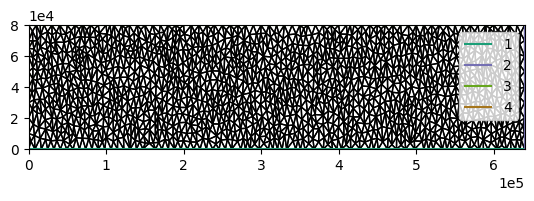

In [3]:
import firedrake
import icepack.plot

def subplots():
    fig, axes = icepack.plot.subplots()
    axes.set_aspect(2)
    axes.set_xlim((0, Lx))
    axes.set_ylim((0, Ly))
    return fig, axes
    
fig, axes = subplots()
firedrake.triplot(coarse_mesh, axes=axes)
axes.legend(loc="upper right");

As we'll see soon, the data structure from MeshPy gives us the freedom to refine triangles locally.

### Input data

We'll use the same bed topography as in the previous guides, but we'll have to recreate it on more than one mesh.
For that reason, it'll be handy to define a function that will create the bed topography for us.

In [4]:
from firedrake import exp, max_value, Constant
def mismip_bed_topography(mesh):
    x, y = firedrake.SpatialCoordinate(mesh)

    x_c = Constant(300e3)
    X = x / x_c

    B_0 = Constant(-150)
    B_2 = Constant(-728.8)
    B_4 = Constant(343.91)
    B_6 = Constant(-50.57)
    B_x = B_0 + B_2 * X**2 + B_4 * X**4 + B_6 * X**6

    f_c = Constant(4e3)
    d_c = Constant(500)
    w_c = Constant(24e3)

    B_y = d_c * (
        1 / (1 + exp(-2 * (y - Ly / 2 - w_c) / f_c)) +
        1 / (1 + exp(+2 * (y - Ly / 2 + w_c) / f_c))
    )

    z_deep = Constant(-720)
    return max_value(B_x + B_y, z_deep)

We'll use the same viscosity and friction values as the previous demos and the same friction law.

In [5]:
A = Constant(20)
C = Constant(1e-2)

In [6]:
from firedrake import sqrt, inner
from icepack.constants import (
    ice_density as ρ_I,
    water_density as ρ_W,
    gravity as g,
    weertman_sliding_law as m,
)

def friction(**kwargs):
    variables = ("velocity", "thickness", "surface", "friction")
    u, h, s, C = map(kwargs.get, variables)

    p_W = ρ_W * g * max_value(0, -(s - h))
    p_I = ρ_I * g * h
    N = max_value(0, p_I - p_W)
    τ_c = N / 2

    u_c = (τ_c / C) ** m
    u_b = sqrt(inner(u, u))

    return τ_c * (
        (u_c**(1 / m + 1) + u_b**(1 / m + 1))**(m / (m + 1)) - u_c
    )

We'll again use a constant accumulation rate of 30 cm/year, but in the second phase of the simulation we'll add melting.

In [7]:
a = Constant(0.3)

We'll be using the same physics model throughout, despite the fact that the spatial domain and the discretization will change.

In [8]:
import icepack
model = icepack.models.IceStream(friction=friction)

### First run

In order to get a better idea of where we need to refine the mesh, we'll start by looking at the results of relatively low-resolution simulations.
Since we'll be running the same simulation many times, we'll again wrap up the code in a function that we can call repeatedly.

In [9]:
from tqdm.notebook import trange
from firedrake import dx

def run_simulation(solver, time, dt, **fields):
    h, s, u, z_b = map(
        fields.get, ("thickness", "surface", "velocity", "bed")
    )
    h_0 = h.copy(deepcopy=True)
    num_steps = int(final_time / dt)
    progress_bar = trange(num_steps)
    for step in progress_bar:
        h = solver.prognostic_solve(
            dt,
            thickness=h,
            velocity=u,
            accumulation=a,
            thickness_inflow=h_0,
        )
        h.interpolate(max_value(h, 1.0))
        s = icepack.compute_surface(thickness=h, bed=z_b)

        u = solver.diagnostic_solve(
            velocity=u,
            thickness=h,
            surface=s,
            fluidity=A,
            friction=C,
        )

        min_h = h.dat.data_ro.min()
        avg_h = firedrake.assemble(h * dx) / (Lx * Ly)
        description = f"avg, min h: {avg_h:4.2f}, {min_h:4.2f}"
        progress_bar.set_description(description)

    return {"thickness": h, "surface": s, "velocity": u}

In [10]:
dt = 3.0
final_time = 3600.0

In [11]:
opts = {
    "dirichlet_ids": [4],
    "side_wall_ids": [1, 3],
    "diagnostic_solver_parameters": {"snes_max_it": 200}
}
solver = icepack.solvers.FlowSolver(model, **opts)

For our initial low-res simulation, we'll use the mesh above with piecewise linear finite elements.

In [12]:
Q1 = firedrake.FunctionSpace(coarse_mesh, "CG", 1)
V1 = firedrake.VectorFunctionSpace(coarse_mesh, "CG", 1)

In [13]:
from firedrake import as_vector, Function

z_b = Function(Q1).interpolate(mismip_bed_topography(coarse_mesh))
h_0 = Function(Q1).assign(Constant(100))
s_0 = icepack.compute_surface(thickness=h_0, bed=z_b)

x = firedrake.SpatialCoordinate(coarse_mesh)[0]
u_0 = solver.diagnostic_solve(
    velocity=Function(V1).interpolate(as_vector((90 * x / Lx, 0))),
    thickness=h_0,
    surface=s_0,
    fluidity=A,
    friction=C,
)

fields = {"surface": s_0, "thickness": h_0, "velocity": u_0}

In [14]:
fields_1 = run_simulation(
    solver, final_time, dt, bed=z_b, **fields
)

  0%|          | 0/1200 [00:00<?, ?it/s]

We were able to compute the results fairly fast, but the coarse mesh resolution is very obvious in the plot of the solution below.
There are clearly spurious artifacts in the shear margins at the top and bottom of the domain.

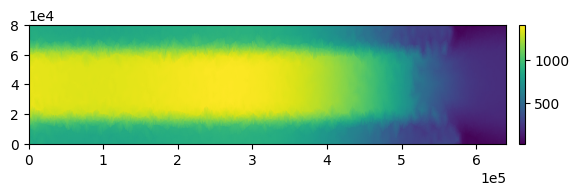

In [15]:
def colorbar(fig, colors):
    return fig.colorbar(colors, fraction=0.012, pad=0.025)

fig, axes = subplots()
colors = firedrake.tripcolor(fields_1["thickness"], axes=axes)
colorbar(fig, colors);

Now we'll repeat the same simulation again at higher resolution by using piecewise quadratic instead of piecewise linear basis functions.

In [16]:
Q2 = firedrake.FunctionSpace(coarse_mesh, "CG", 2)
V2 = firedrake.VectorFunctionSpace(coarse_mesh, "CG", 2)

In [17]:
z_b = Function(Q2).interpolate(mismip_bed_topography(coarse_mesh))

In [18]:
h_0 = Function(Q2).assign(Constant(100))
s_0 = icepack.compute_surface(thickness=h_0, bed=z_b)

x = firedrake.SpatialCoordinate(coarse_mesh)[0]
solver = icepack.solvers.FlowSolver(model, **opts)
u_0 = solver.diagnostic_solve(
    velocity=Function(V2).interpolate(as_vector((90 * x / Lx, 0))),
    thickness=h_0,
    surface=s_0,
    fluidity=A,
    friction=C,
)

fields = {"thickness": h_0, "surface": s_0, "velocity": u_0}

In [19]:
fields_2 = run_simulation(
    solver, final_time, dt, bed=z_b, **fields
)

  0%|          | 0/1200 [00:00<?, ?it/s]

To get an idea of where we're making the largest errors, we can look at the discrepancy between the degree-1 and degree-2 simulations.

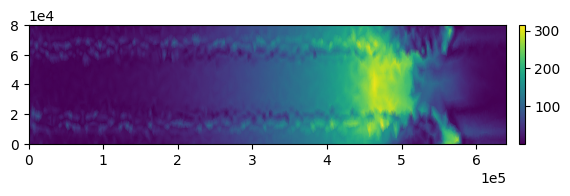

In [20]:
expr = abs(fields_2["thickness"] - fields_1["thickness"])
δh = Function(Q2).interpolate(expr)

fig, axes = subplots()
colors = firedrake.tripcolor(δh, axes=axes)
colorbar(fig, colors);

Perhaps not surprisingly, the biggest misfits occur near the grounding line.
Now that we know where we need more triangles, how do we go about refining the mesh?

### Refinement

Before actually refining the mesh, we'll want to create a new field that smooths over the thickness error in space.
This will help give a more continuous gradation between coarse and fine triangles rather than a sudden jump.

In [21]:
from firedrake import dS

DG0 = firedrake.FunctionSpace(coarse_mesh, "DG", 0)
ϵ = firedrake.Function(DG0)
J = 0.5 * (
    (ϵ - δh)**2 * dx
    + (Ly / 2) * (ϵ("+") - ϵ("-"))**2 * dS
)
F = firedrake.derivative(J, ϵ)
firedrake.solve(F == 0, ϵ)

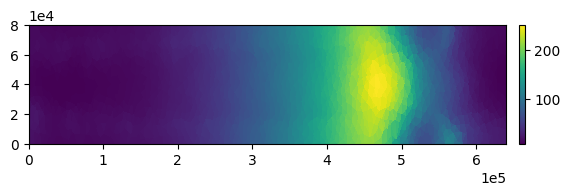

In [22]:
fig, axes = subplots()
colors = firedrake.tripcolor(ϵ, axes=axes)
colorbar(fig, colors);

The `element_volumes` member of the Triangle mesh data structure contains an array that we'll fill in order to specify the desired triangle areas in the refined mesh.
This array isn't initialized by default.
The setup routine below allocates space for it.

In [23]:
triangle_mesh.element_volumes.setup()

Now we have to make some decisions about how much to actually refine the mesh.
Here we'll specify arbitrarily that the triangles with the largest errors will have their areas shrunk by a factor of 8.
We then have to decide how much to shrink the areas of triangles with less than the largest error.
The scaling could be linear, or quadratic, or the square root -- this is up to us.
For this problem, we'll use a quadratic scaling; this makes for fewer triangles than if we had used linear scaling.

In [24]:
expr = firedrake.CellVolume(coarse_mesh)
areas = firedrake.project(expr, DG0)

shrink = 8
exponent = 2
max_err = ϵ.dat.data_ro[:].max()

num_triangles = len(triangle_mesh.elements)
for index, err in enumerate(ϵ.dat.data_ro[:]):
    area = areas.dat.data_ro[index]
    shrink_factor = shrink * (err / max_err)**exponent
    triangle_mesh.element_volumes[index] = area / (1 + shrink_factor)
    
refined_triangle_mesh = triangle.refine(triangle_mesh)

Once again we'll use the convenience function `triangle_to_firedrake` to convert the Triangle data structure into a Firedrake data structure.

In [25]:
fine_mesh = icepack.meshing.triangle_to_firedrake(refined_triangle_mesh)

The figure below shows approximate position of the grounding line on the old mesh, overlaid on top of the new mesh.
We've zoomed in on part of the domain so you can see how much more refined the mesh is in the neighborhood of the grounding line.

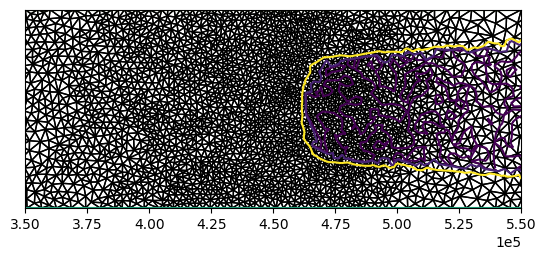

In [26]:
fig, axes = icepack.plot.subplots()
axes.set_xlim((350e3, 550e3))
axes.set_ylim((0, 80e3))
axes.get_yaxis().set_visible(False)

s = fields_2["surface"]
h = fields_2["thickness"]
height_above_flotation = Function(Q2).interpolate(s - (1 - ρ_I / ρ_W) * h)
levels = [0, 1, 10]
contours = firedrake.tricontour(
    height_above_flotation, levels=levels, axes=axes
)

firedrake.triplot(fine_mesh, axes=axes);

### Second run

Now that we have a refined mesh, we can project our old solutions on the coarse mesh to it and run the physics out for a further several thousand years to get even closer to the equilibrium solution.

In [27]:
Q1 = firedrake.FunctionSpace(fine_mesh, "CG", 1)
V1 = firedrake.VectorFunctionSpace(fine_mesh, "CG", 1)

In [28]:
h_0 = Function(Q1).project(fields_2["thickness"])
u_0 = Function(V1).project(fields_2["velocity"])

z_b = Function(Q1).interpolate(mismip_bed_topography(fine_mesh))
s_0 = icepack.compute_surface(thickness=h_0, bed=z_b)

solver = icepack.solvers.FlowSolver(model, **opts)
u_0 = solver.diagnostic_solve(
    velocity=u_0, thickness=h_0, surface=s_0, fluidity=A, friction=C
)

fields = {"surface": s_0, "thickness": h_0, "velocity": u_0}

In [29]:
final_time = 900.0
dt = 1.0
fields_1 = run_simulation(
    solver, final_time, dt, bed=z_b, **fields
)

  0%|          | 0/900 [00:00<?, ?it/s]

And now for the higher-resolution run.

In [30]:
Q2 = firedrake.FunctionSpace(fine_mesh, "CG", 2)
V2 = firedrake.VectorFunctionSpace(fine_mesh, "CG", 2)

In [31]:
h_0 = Function(Q2).project(fields_2["thickness"])
u_0 = Function(V2).project(fields_2["velocity"])

z_b = Function(Q1).interpolate(mismip_bed_topography(fine_mesh))
s_0 = icepack.compute_surface(thickness=h_0, bed=z_b)

solver = icepack.solvers.FlowSolver(model, **opts)
u_0 = solver.diagnostic_solve(
    velocity=u_0, thickness=h_0, surface=s_0, fluidity=A, friction=C
)

fields = {"surface": s_0, "thickness": h_0, "velocity": u_0}

In [32]:
fields_2 = run_simulation(
    solver, final_time, dt, bed=z_b, **fields
)

  0%|          | 0/900 [00:00<?, ?it/s]

And finally we can look at the results.
The first thing to notice is that the discrepancies between the high- and the low-resolution runs are much reduced now that we've refined the mesh.

In [33]:
expr = fields_2["thickness"] - fields_1["thickness"]
δh = Function(Q2).interpolate(abs(expr))

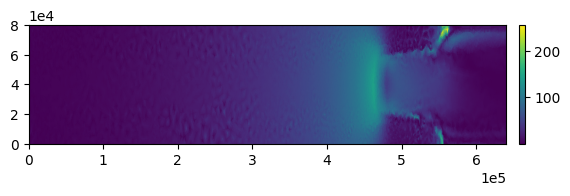

In [34]:
fig, axes = subplots()
colors = firedrake.tripcolor(δh, axes=axes)
colorbar(fig, colors);

Next we can look at a plot of the thickness itself.

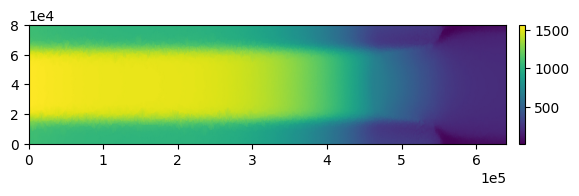

In [35]:
fig, axes = subplots()
colors = firedrake.tripcolor(fields_2["thickness"], axes=axes)
colorbar(fig, colors);

The runs on the coarse mesh showed obvious grid-imprinting artifacts in the shear margins.
While the results aren't perfect on the higher-resolution mesh, things are now much improved.

### Conclusion

The code that we've shown above demonstrates how to refine the mesh according to criteria of your choosing.
We used an interface to Triangle through the package MeshPy to do that, but first we had to do two things:

1. **Estimate the errors.**
We used the discrepancy in thickness between a lower and a higher-order finite element basis as a proxy for the true error, which we cannot know.
2. **Decide how much to refine the mesh and where.**
We came up with a completely arbitrary area scaling formula through trial and error.
It happened to work ok.

There are alternative approaches for each of these steps.
Another common method for error estimation is to measure the *gradient reconstruction* error.
If we used, say, a continuous piecewise quadratic basis for the thickness, its gradient would be a discontinuous field.
The idea of gradient reconstruction is to project the discontinuous, exact value of the gradient field back onto the basis CG(2) that we used in the first place.
The discrepancy between the exact gradient and the reconstruction tells us something about the error.
This is only one approach and there are many more ways to do *a posteriori error estimation*.

To make a more informed decision about where to refine the mesh, we can try to equally distribute the error according to the estimate we've already obtained above.
We could also have guessed that we'll need lots of triangles near the glacier grounding line before we went to solve anything.
In that case, we're using specific domain knowledge about the problem rather than a posteriori error estimates.
This is also a good idea and you can always use a posteriori error estimates to guide further refinements.

There is a more scientific way to approach a posteriori error estimation and mesh refinement based on finding the derivative of a certain *goal functional* -- which plays a similar role to the objective functional in an inverse problem -- with respect to the state variables.
If you want to learn more, the book by [Bangerth and Rannacher](https://doi.org/10.1007/978-3-0348-7605-6) is a great reference.

In this demonstration, we used only a single cycle of simulate, estimate, refine, simulate again.
You can of course repeat the loop more than once to add further refinement levels.
You can also apply the same principles to decide how to adapatively choose the timestep -- rather than use a single time integration loop, run a low-res simulation with timestep $\delta t$ and a high-res one with timestep $\delta t / 2$.
The approach we've shown here is pretty rudimentary and leaves a lot up to you.
Using these ideas can be a huge help in solving practical problems, but it requires a lot of experimentation.